In [1]:
import mne
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from keras.models import Sequential
from keras.layers import LSTM, Dense,Dropout,TimeDistributed,GlobalAveragePooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE

In [2]:
# โหลดข้อมูล
df = pd.read_csv("C:\\Users\\ADMIN\Project\\.venv\\Sleep testFiltered_EEG_Data1.csv")

<>:2: SyntaxWarning: invalid escape sequence '\P'
<>:2: SyntaxWarning: invalid escape sequence '\P'
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_25300\2419121426.py:2: SyntaxWarning: invalid escape sequence '\P'
  df = pd.read_csv("C:\\Users\\ADMIN\Project\\.venv\\Sleep testFiltered_EEG_Data1.csv")


In [3]:
channel_map = {
    "1": "EEG F4-M1",
    "2": "EEG C4-M1",
    "3": "EEG O2-M1",
    "4": "EEG C3-M2",
    "5": "EMG chin",
    "6": "EOG E1-M2",
    "7": "EOG E2-M2",
    "8": "ECG"
}
# เปลี่ยนชื่อ column ใน DataFrame
df = df.rename(columns=channel_map)

# ตรวจสอบ
print(df.head())

       Time  EEG F4-M1  EEG C4-M1  EEG O2-M1  EEG C3-M2  EMG chin  EOG E1-M2  \
0  0.000000  -0.332139   1.460207  -0.082405   0.945965 -0.556532   8.282122   
1  0.003906   0.455678  -0.506964  -8.182390   2.241613  3.137224  18.753385   
2  0.007812  -0.995135  -3.805043 -15.517629   2.785924  5.121238  26.958536   
3  0.011719  -5.017469  -7.255061 -18.758616   1.417463  5.081020  29.945681   
4  0.015625 -10.258652  -9.017413 -16.288979  -2.295541  4.092776  27.027844   

   EOG E2-M2        ECG      Annotation  
0  -6.846270 -36.322502   Sleep stage W  
1  -6.397049 -36.334116   Sleep stage W  
2  -7.204251 -37.603388   Sleep stage W  
3  -9.951360 -42.065282   Sleep stage W  
4 -13.573874 -50.681696   Sleep stage W  


In [4]:
data = df.drop(['Annotation','Time'], axis=1)
labels = df['Annotation']

In [5]:
N2,W,R,N1,N3=labels.value_counts()
print(N2+W+R+N1+N3)
print(labels.value_counts())

6558720
Annotation
Sleep stage N2    3302400
Sleep stage W     1159680
Sleep stage R     1082880
Sleep stage N1     837120
Sleep stage N3     176640
Name: count, dtype: int64


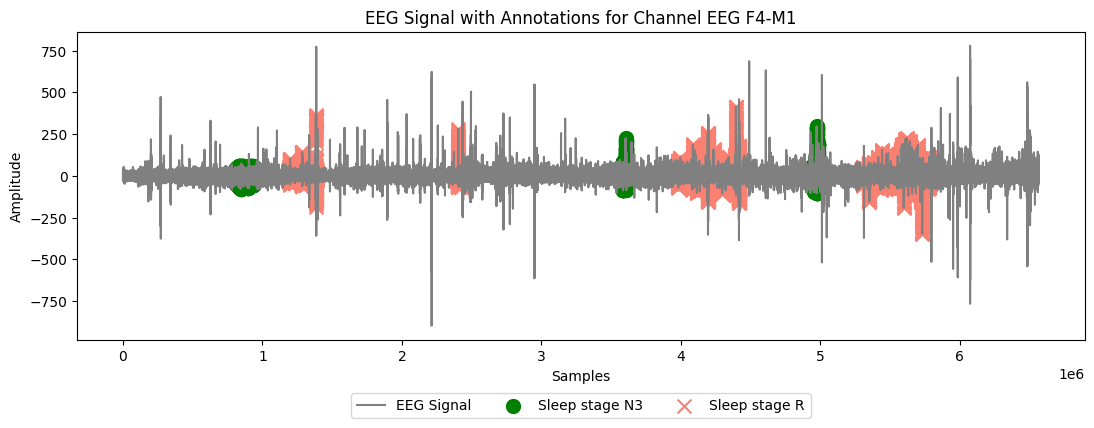

In [6]:
plt.figure(figsize=(13, 4))
plt.plot(df.index, df['EEG F4-M1'], c = 'gray',label='EEG Signal')
plt.scatter(df.index[df['Annotation'] == ' Sleep stage N3'], df['EEG F4-M1'][df['Annotation'] == ' Sleep stage N3'], c = 'green', label='Sleep stage N3', s=100, marker='o')
plt.scatter(df.index[df['Annotation'] == ' Sleep stage R'], df['EEG F4-M1'][df['Annotation'] == ' Sleep stage R'], c = 'salmon', label='Sleep stage R', s=100, marker='x')

plt.title("EEG Signal with Annotations for Channel EEG F4-M1")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

plt.show()

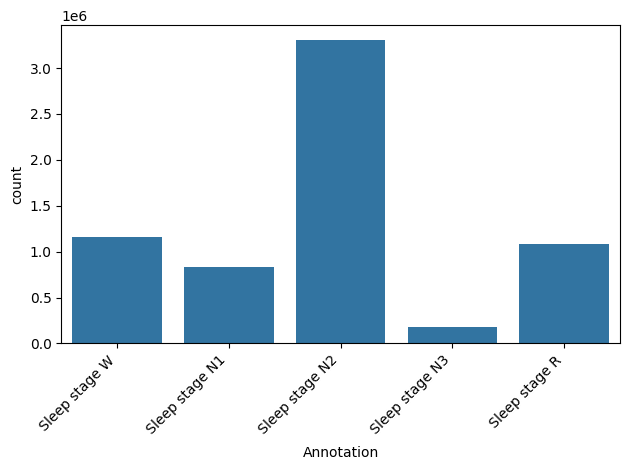

The number of Sleep stage Wake is: 1159680
The number of Sleep stage N1 is: 837120
The number of Sleep stage N2 is: 3302400
The number of Sleep stage N3 is: 176640
The number of Sleep stage N4 is: 1082880


(np.float64(-1.099999935444984),
 np.float64(1.100000012416193),
 np.float64(-1.0999999580006097),
 np.float64(1.099999998000029))

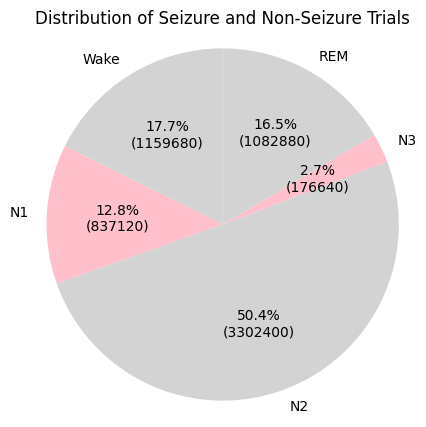

In [7]:
# Assuming 'labels' is a Series or list containing your label data
sns.countplot(x=labels)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Calculate the number of non-seizure and seizure trials
N2,W,R,N1,N3 = labels.value_counts()

# Print the counts
print('The number of Sleep stage Wake is:', W)
print('The number of Sleep stage N1 is:', N1)
print('The number of Sleep stage N2 is:', N2)
print('The number of Sleep stage N3 is:', N3)
print('The number of Sleep stage N4 is:', R)
# Create a pie chart with percentage and number of samples
labels_counts = [W,N1,N2,N3,R]
labels_names = ['Wake','N1','N2','N3','REM']

def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        absolute = int(round(pct/100.*total))
        return f"{pct:.1f}%\n({absolute})"
    return my_format

plt.figure(figsize=(5, 5))
plt.pie(labels_counts, labels=labels_names, autopct=autopct_format(labels_counts), startangle=90, colors=['lightgrey', 'pink'])
plt.title('Distribution of Seizure and Non-Seizure Trials')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Display the pie chart

In [8]:
# train-test split for time series
train_size = int(len(data) * 0.5)
val_size = int(len(data) * 0.75)
X_train_df, X_val_df, X_test_df = data[:train_size], data[train_size+1:val_size], data[val_size+1:]
y_train_df, y_val_df, y_test_df = labels[:train_size], labels[train_size+1:val_size], labels[val_size+1:]
X_train_df.shape, X_val_df.shape, X_test_df.shape, y_train_df.shape, y_val_df.shape, y_test_df.shape

((3283200, 8), (1641599, 8), (1641599, 8), (3283200,), (1641599,), (1641599,))

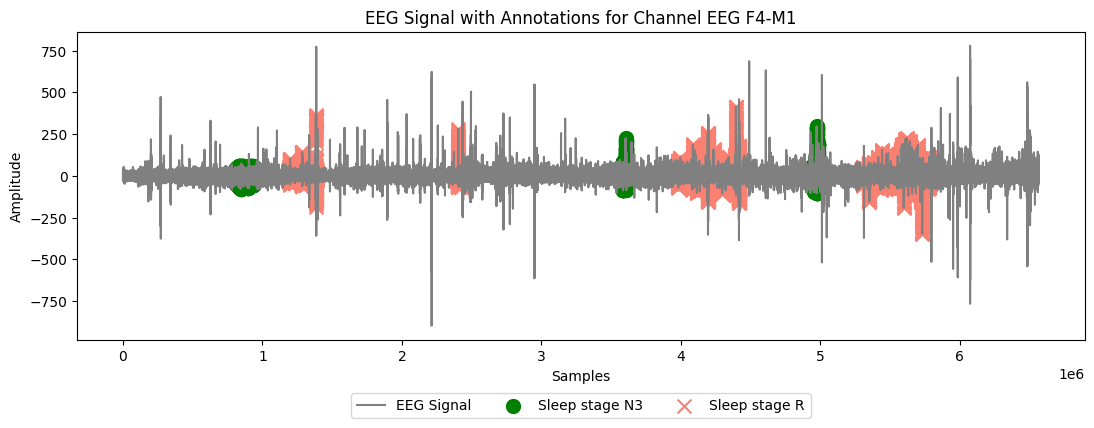

In [9]:
plt.figure(figsize=(13, 4))
plt.plot(df.index, df['EEG F4-M1'], c = 'gray',label='EEG Signal')
plt.scatter(df.index[df['Annotation'] == ' Sleep stage N3'], df['EEG F4-M1'][df['Annotation'] == ' Sleep stage N3'], c = 'green', label='Sleep stage N3', s=100, marker='o')
plt.scatter(df.index[df['Annotation'] == ' Sleep stage R'], df['EEG F4-M1'][df['Annotation'] == ' Sleep stage R'], c = 'salmon', label='Sleep stage R', s=100, marker='x')

plt.title("EEG Signal with Annotations for Channel EEG F4-M1")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

plt.show()

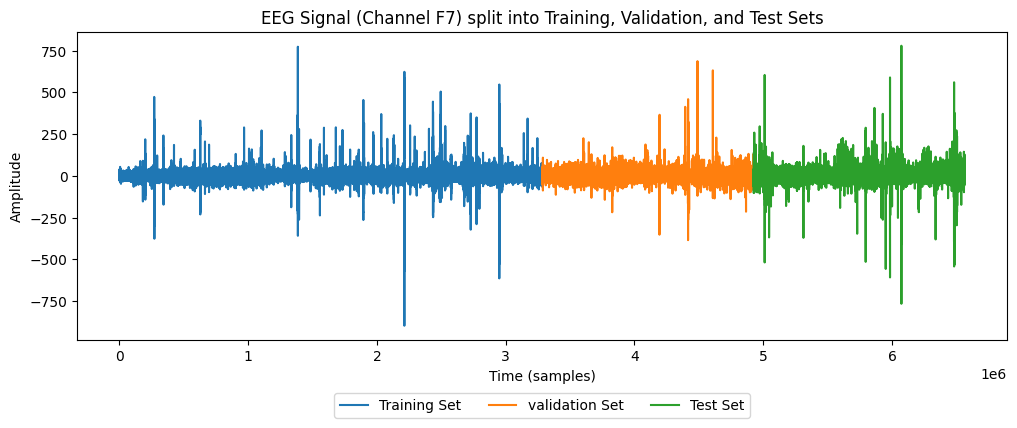

In [10]:
plt.figure(figsize=(12,4))
plt.plot(X_train_df['EEG F4-M1'], label='Training Set')
plt.plot(X_val_df['EEG F4-M1'], label='validation Set')
plt.plot(X_test_df['EEG F4-M1'], label='Test Set')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.title("EEG Signal (Channel F7) split into Training, Validation, and Test Sets")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")

plt.show()

In [11]:
y_train_df.value_counts(), y_val_df.value_counts(), y_test_df.value_counts()

(Annotation
 Sleep stage N2    1585920
 Sleep stage W      867840
 Sleep stage N1     529920
 Sleep stage R      199680
 Sleep stage N3      99840
 Name: count, dtype: int64,
 Annotation
 Sleep stage N2    1004159
 Sleep stage R      430080
 Sleep stage N1     130560
 Sleep stage N3      38400
 Sleep stage W       38400
 Name: count, dtype: int64,
 Annotation
 Sleep stage N2    712319
 Sleep stage R     453120
 Sleep stage W     253440
 Sleep stage N1    176640
 Sleep stage N3     38400
 Name: count, dtype: int64)

### Oversampling

In [15]:
smt = SMOTE(sampling_strategy='minority', random_state=42, k_neighbors=5)
X_train_df, y_train_df = smt.fit_resample(X_train_df, y_train_df)

print(y_train_df.value_counts())
print(y_val_df.value_counts())
print(y_test_df.value_counts())

Annotation
Sleep stage W     1585920
Sleep stage N1    1585920
Sleep stage N2    1585920
Sleep stage N3    1585920
Sleep stage R     1585920
Name: count, dtype: int64
Annotation
Sleep stage N2    1004159
Sleep stage R      430080
Sleep stage N1     130560
Sleep stage N3      38400
Sleep stage W       38400
Name: count, dtype: int64
Annotation
Sleep stage N2    712319
Sleep stage R     453120
Sleep stage W     253440
Sleep stage N1    176640
Sleep stage N3     38400
Name: count, dtype: int64


In [17]:
X_train_df.shape, X_val_df.shape, X_test_df.shape

((7929600, 8), (1641599, 8), (1641599, 8))

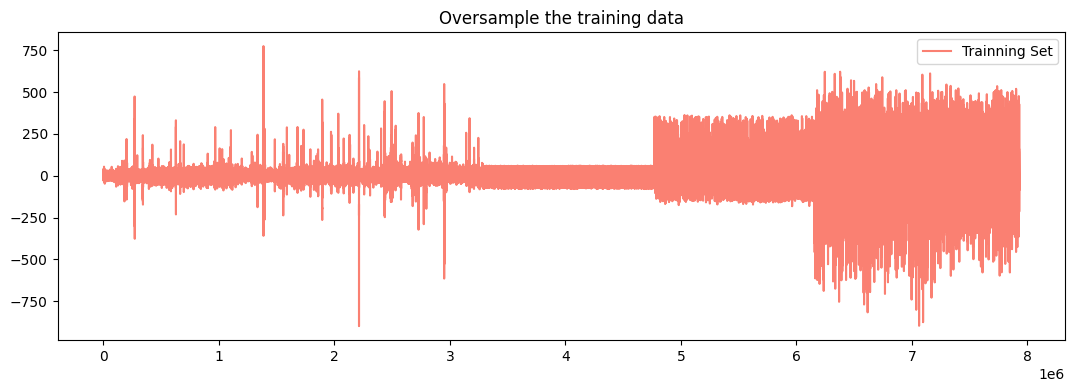

In [18]:
plt.figure(figsize=(13,4))
plt.plot(X_train_df['EEG F4-M1'], color='salmon', label='Trainning Set')
plt.legend()
plt.title('Oversample the training data')
plt.show()

### Select Channel

In [19]:
X_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7929600 entries, 0 to 7929599
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   EEG F4-M1  float64
 1   EEG C4-M1  float64
 2   EEG O2-M1  float64
 3   EEG C3-M2  float64
 4   EMG chin   float64
 5   EOG E1-M2  float64
 6   EOG E2-M2  float64
 7   ECG        float64
dtypes: float64(8)
memory usage: 484.0 MB


In [20]:
selected_channels = ['EEG F4-M1', 'EEG C4-M1', 'EEG O2-M1','EEG C3-M2']

# Create the new DataFrame with only the selected channels
X_train_df_reduced = X_train_df[selected_channels]
X_val_df_reduced = X_val_df[selected_channels]
X_test_df_reduced = X_test_df[selected_channels]

X_train_df_reduced.shape, X_val_df_reduced.shape, X_test_df_reduced.shape

((7929600, 4), (1641599, 4), (1641599, 4))

### Create Sliding Window

In [21]:
def apply_sliding_window(data, label, window_size, step_size):
    # Reset index เพื่อให้ iloc ทำงานชัวร์
    data = data.reset_index(drop=True)
    label = label.reset_index(drop=True)

    window_data = []
    window_label = []

    for i in range(0, len(data) - window_size + 1, step_size):
        window = data.iloc[i:i + window_size]
        label_slice = label.iloc[i:i + window_size]

        if len(label_slice) == 0 or label_slice.mode().empty:
            continue  # ข้าม window ที่ไม่มีข้อมูล

        label_value = label_slice.mode().iloc[0]

        window_data.append(window)
        window_label.append(label_value)

    X = np.array(window_data)
    y = np.array(window_label)
    return X, y


In [22]:
# Define parameters
window_size = 256
step_size = 128

# Apply sliding window function to the train/test set
X_train, y_train =  apply_sliding_window(X_train_df, y_train_df, window_size, step_size)
X_val, y_val =  apply_sliding_window(X_val_df, y_val_df, window_size, step_size)
X_test, y_test = apply_sliding_window(X_test_df, y_test_df, window_size, step_size)

X_train_reduced, y_train_reduced =  apply_sliding_window(X_train_df_reduced, y_train_df, window_size, step_size)
X_val_reduced, y_val_reduced =  apply_sliding_window(X_val_df_reduced, y_val_df, window_size, step_size)
X_test_reduced, y_test_reduced = apply_sliding_window(X_test_df_reduced, y_test_df, window_size, step_size)

print("X_train:" ,X_train.shape, ", y_train:", y_train.shape)
print("X_val:" ,X_val.shape, ", y_val:", y_val.shape)
print("X_test:" ,X_test.shape, ", y_test:", y_test.shape)

print("X_train_reduced:" ,X_train_reduced.shape, ", y_train_reduced:", y_train_reduced.shape)
print("X_val_reduced:" ,X_val_reduced.shape, ", y_val_reduced:", y_val_reduced.shape)
print("X_test_reduced:" ,X_test_reduced.shape, ", y_test_reduced:", y_test_reduced.shape)

X_train: (61949, 256, 8) , y_train: (61949,)
X_val: (12823, 256, 8) , y_val: (12823,)
X_test: (12765, 256, 8) , y_test: (12765,)
X_train_reduced: (61949, 256, 4) , y_train_reduced: (61949,)
X_val_reduced: (12823, 256, 4) , y_val_reduced: (12823,)
X_test_reduced: (12765, 256, 4) , y_test_reduced: (12765,)


Sample (original y_train_df):
Annotation
Sleep stage W     1585920
Sleep stage N1    1585920
Sleep stage N2    1585920
Sleep stage N3    1585920
Sleep stage R     1585920
Name: count, dtype: int64
After Sliding Window (selected channels y_train_reduced):
Sleep stage N1    12413
Sleep stage R     12386
Sleep stage N3    12385
Sleep stage N2    12384
Sleep stage W     12381
Name: count, dtype: int64
                N Sample
Annotation              
Sleep stage W    1585920
Sleep stage N1   1585920
Sleep stage N2   1585920
Sleep stage N3   1585920
Sleep stage R    1585920


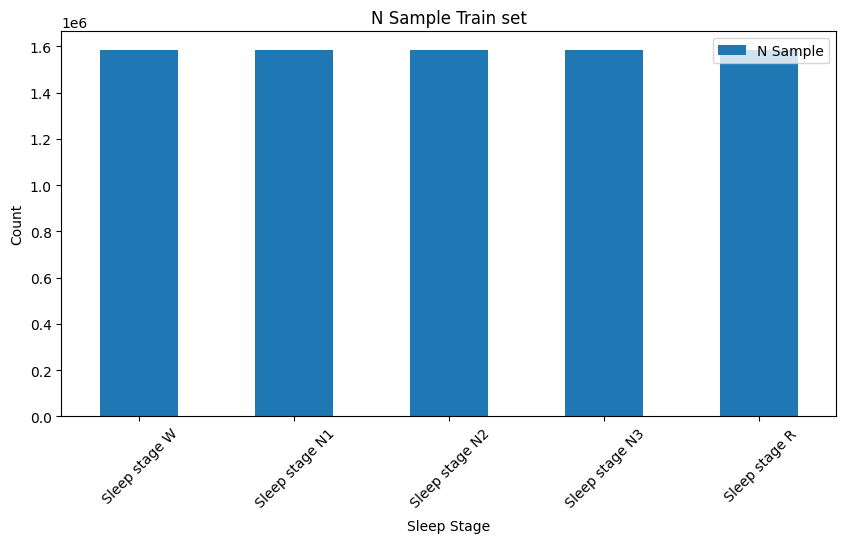

Annotation
Sleep stage W     20.0
Sleep stage N1    20.0
Sleep stage N2    20.0
Sleep stage N3    20.0
Sleep stage R     20.0
Name: proportion, dtype: float64


In [23]:
print("Sample (original y_train_df):")
print(y_train_df.value_counts())
print("After Sliding Window (selected channels y_train_reduced):")
print(pd.Series(y_train_reduced).value_counts())
# รวมผลเป็น DataFrame เพื่อเทียบง่าย ๆ
annotation_check = pd.DataFrame({
    "N Sample": y_train_df.value_counts(),
}).fillna(0).astype(int)

print(annotation_check)
annotation_check.plot(kind="bar", figsize=(10, 5))
plt.title("N Sample Train set")
plt.ylabel("Count")
plt.xlabel("Sleep Stage")
plt.xticks(rotation=45)
plt.show()
print(y_train_df.value_counts(normalize=True) * 100)

## Train

### CNN

In [24]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
# -----------------------------
# 1. แปลง label เป็นตัวเลข + one-hot
# -----------------------------
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_val_enc   = encoder.transform(y_val)
y_test_enc  = encoder.transform(y_test)

num_classes = len(np.unique(y_train_enc))

y_train_cat = to_categorical(y_train_enc, num_classes=num_classes)
y_val_cat   = to_categorical(y_val_enc, num_classes=num_classes)
y_test_cat  = to_categorical(y_test_enc, num_classes=num_classes)

# -----------------------------
# 2. แปลง X ให้เป็น float32 และ shape = (samples, timesteps, features)
# -----------------------------
X_train = np.array(X_train, dtype=np.float32)
X_val   = np.array(X_val, dtype=np.float32)
X_test  = np.array(X_test, dtype=np.float32)

if X_train.ndim == 2:
    X_train = X_train[..., np.newaxis]
    X_val   = X_val[..., np.newaxis]
    X_test  = X_test[..., np.newaxis]

print("X_train shape:", X_train.shape)  # (samples, timesteps, channels)
print("y_train shape:", y_train_cat.shape)

# -----------------------------
# 3. สร้าง CNN model
# -----------------------------
model_cnn = Sequential([
    Conv1D(filters=32, kernel_size=7, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=64, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=64, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model_cnn.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model_cnn.summary()

NameError: name 'LabelEncoder' is not defined

In [ ]:
# -----------------------------
# 4. Train CNN model
# -----------------------------
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_cnn_model.keras', monitor='val_loss', save_best_only=True)
]
history = model_cnn.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=80,
    batch_size=32,
    shuffle=True,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/80
1936/1936 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.7590 - loss: 0.6109 - val_accuracy: 0.6266 - val_loss: 1.4021
Epoch 2/80
1936/1936 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.8817 - loss: 0.3253 - val_accuracy: 0.6182 - val_loss: 1.5376
Epoch 3/80
1936/1936 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.8957 - loss: 0.2840 - val_accuracy: 0.6490 - val_loss: 1.3238
Epoch 4/80
1936/1936 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.9010 - loss: 0.2655 - val_accuracy: 0.6367 - val_loss: 1.1590
Epoch 5/80
1936/1936 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.9057 - loss: 0.2503 - val_accuracy: 0.6420 - val_loss: 1.7103
Epoch 6/80
1936/1936 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.9126 - loss: 0.2323 - val_accuracy: 0.6282 - val_loss: 1.7693
Epoch 7/80
1936/1936 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.9145 - loss: 0.2268 - val_accuracy: 0.6521 - val_loss: 1.7202
Epoch 8/80
1936/1936 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.9198 - loss: 0

In [27]:
# -----------------------------
# 5. Evaluate model
# -----------------------------
loss, accuracy = model_cnn.evaluate(X_test, y_test_cat)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%")

399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4644 - loss: 5.6371
Test Loss: 5.6371, Test Accuracy: 46.44%


In [28]:
threshold = 0.5  # set the threshold value
y_pred_prob = model_cnn.predict(X_test)  # generate prediction probabilities
y_pred = (y_pred_prob > threshold).astype(int)

399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


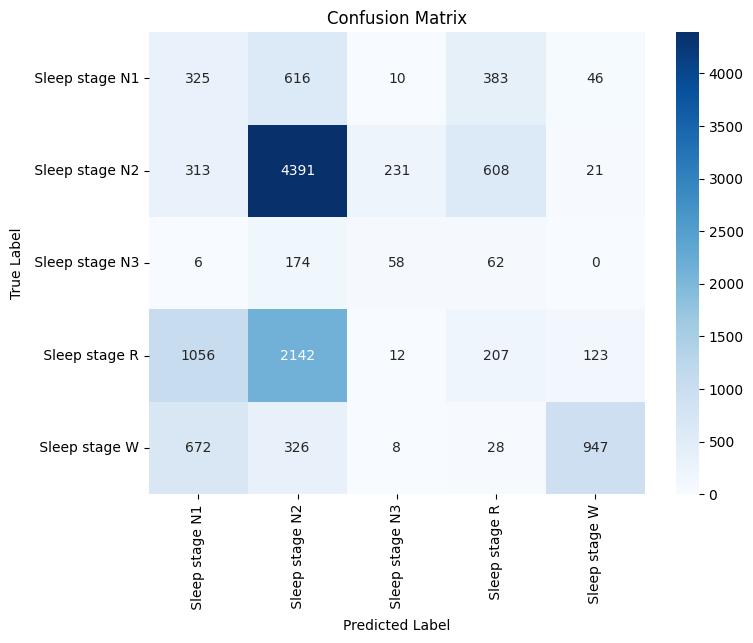

                 precision    recall  f1-score   support

 Sleep stage N1       0.14      0.24      0.17      1380
 Sleep stage N2       0.57      0.79      0.66      5564
 Sleep stage N3       0.18      0.19      0.19       300
  Sleep stage R       0.16      0.06      0.09      3540
  Sleep stage W       0.83      0.48      0.61      1981

       accuracy                           0.46     12765
      macro avg       0.38      0.35      0.34     12765
   weighted avg       0.44      0.46      0.43     12765



In [29]:
# --------------------------
# 1. Predict labels
# --------------------------
y_pred_probs = model_cnn.predict(X_test)   # ได้เป็น probability (softmax)
y_pred = np.argmax(y_pred_probs, axis=1)  # แปลงเป็น class index
y_true = np.argmax(y_test_cat, axis=1)    # แปลง one-hot y_test กลับเป็น index

# --------------------------
# 2. Confusion matrix
# --------------------------
cm = confusion_matrix(y_true, y_pred)

# --------------------------
# 3. Plot confusion matrix
# --------------------------
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# --------------------------
# 4. (optional) Classification report
# --------------------------
print(classification_report(y_true, y_pred, target_names=encoder.classes_))

## ลองทำ CNN+Class weight

In [30]:
# -----------------------------
# 1. Encode labels
# -----------------------------
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_val_enc   = encoder.transform(y_val)
y_test_enc  = encoder.transform(y_test)

num_classes = len(np.unique(y_train_enc))

y_train_cat = to_categorical(y_train_enc, num_classes=num_classes)
y_val_cat   = to_categorical(y_val_enc, num_classes=num_classes)
y_test_cat  = to_categorical(y_test_enc, num_classes=num_classes)

# -----------------------------
# 2. Compute class weights
# -----------------------------
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_enc),
    y=y_train_enc
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

# -----------------------------
# 3. CNN model
# -----------------------------
model_cnn = Sequential([
    Conv1D(filters=32, kernel_size=7, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=64, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=64, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model_cnn.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
model_cnn.summary()

Class Weights: {0: np.float64(0.9981309917022476), 1: np.float64(1.00046834625323), 2: np.float64(1.0003875656035526), 3: np.float64(1.0003067979977394), 4: np.float64(1.000710766497052)}


C:\Users\ADMIN\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 250, 32)        │         1,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 250, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 125, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 121, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 121, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 58, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 58, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 29, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 25, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 25, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,085 (695.64 KB)

 Trainable params: 177,509 (693.39 KB)

 Non-trainable params: 576 (2.25 KB)

In [31]:
# -----------------------------
# 4. Train CNN model
# -----------------------------
history = model_cnn.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=80,
    batch_size=32,
    shuffle=True,
)

Epoch 1/80
1936/1936 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.7679 - loss: 0.6033 - val_accuracy: 0.6281 - val_loss: 1.0209
Epoch 2/80
1936/1936 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.8820 - loss: 0.3275 - val_accuracy: 0.6116 - val_loss: 1.2138
Epoch 3/80
1936/1936 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.8947 - loss: 0.2871 - val_accuracy: 0.6225 - val_loss: 1.6726
Epoch 4/80
1936/1936 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.9000 - loss: 0.2714 - val_accuracy: 0.6248 - val_loss: 1.5184
Epoch 5/80
1936/1936 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.9066 - loss: 0.2506 - val_accuracy: 0.6457 - val_loss: 1.3658
Epoch 6/80
1936/1936 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.9089 - loss: 0.2415 - val_accuracy: 0.6420 - val_loss: 1.2050
Epoch 7/80
1936/1936 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.9142 - loss: 0.2305 - val_accuracy: 0.6289 - val_loss: 1.8403
Epoch 8/80
1936/1936 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.9178 - loss: 0

In [32]:
# -----------------------------
# 5. Evaluate model
# -----------------------------
loss, accuracy = model_cnn.evaluate(X_test, y_test_cat)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%")

399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5145 - loss: 5.1081
Test Loss: 5.1081, Test Accuracy: 51.45%


In [33]:
threshold = 0.5  # set the threshold value
y_pred_prob = model_cnn.predict(X_test)  # generate prediction probabilities
y_pred = (y_pred_prob > threshold).astype(int)

399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


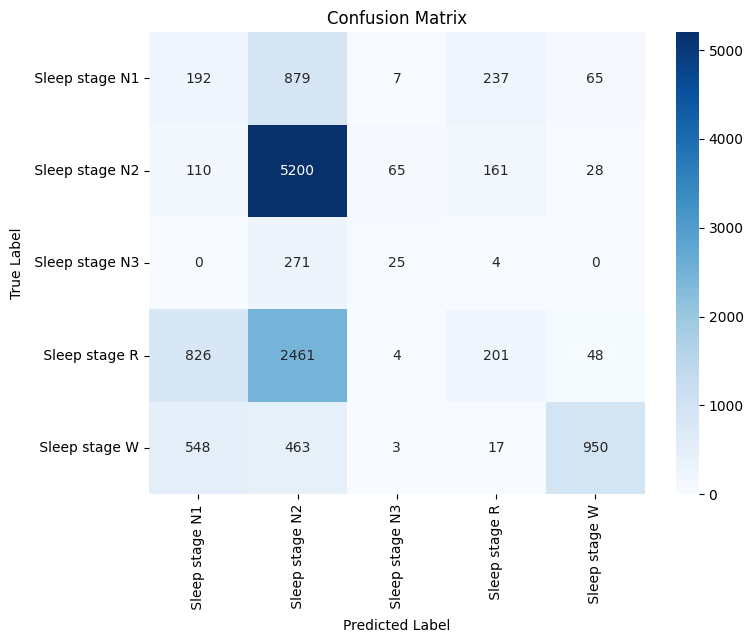

                 precision    recall  f1-score   support

 Sleep stage N1       0.11      0.14      0.13      1380
 Sleep stage N2       0.56      0.93      0.70      5564
 Sleep stage N3       0.24      0.08      0.12       300
  Sleep stage R       0.32      0.06      0.10      3540
  Sleep stage W       0.87      0.48      0.62      1981

       accuracy                           0.51     12765
      macro avg       0.42      0.34      0.33     12765
   weighted avg       0.49      0.51      0.44     12765



In [34]:
# --------------------------
# 1. Predict labels
# --------------------------
y_pred_probs = model_cnn.predict(X_test)   # ได้เป็น probability (softmax)
y_pred = np.argmax(y_pred_probs, axis=1)  # แปลงเป็น class index
y_true = np.argmax(y_test_cat, axis=1)    # แปลง one-hot y_test กลับเป็น index

# --------------------------
# 2. Confusion matrix
# --------------------------
cm = confusion_matrix(y_true, y_pred)

# --------------------------
# 3. Plot confusion matrix
# --------------------------
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# --------------------------
# 4. (optional) Classification report
# --------------------------
print(classification_report(y_true, y_pred, target_names=encoder.classes_))

## CNN+LSTM+Class weight

In [62]:
# -----------------------------
# 1. แปลง label เป็นตัวเลข + one-hot
# -----------------------------
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_val_enc   = encoder.transform(y_val)
y_test_enc  = encoder.transform(y_test)

num_classes = len(np.unique(y_train_enc))

y_train_cat = to_categorical(y_train_enc, num_classes=num_classes)
y_val_cat   = to_categorical(y_val_enc, num_classes=num_classes)
y_test_cat  = to_categorical(y_test_enc, num_classes=num_classes)

# -----------------------------
# 2. แปลง X ให้เป็น float32
# -----------------------------
X_train = np.array(X_train, dtype=np.float32)
X_val   = np.array(X_val, dtype=np.float32)
X_test  = np.array(X_test, dtype=np.float32)

if X_train.ndim == 2:  # reshape ให้เป็น (samples, timesteps, features)
    X_train = X_train[..., np.newaxis]
    X_val   = X_val[..., np.newaxis]
    X_test  = X_test[..., np.newaxis]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train_cat.shape)

# -----------------------------
# 3. สร้าง LSTM model
# -----------------------------

model1 = Sequential()

# 1D CNN layer
model1.add(Conv1D(filters=64, kernel_size=3, activation='relu',
                  input_shape=(X_train.shape[1], X_train.shape[2])))
model1.add(MaxPooling1D(pool_size=2))
model1.add(Dropout(0.1))

# LSTM layer
model1.add(LSTM(64, return_sequences=False))  # return_sequences=False เพราะต่อ Dense

# Output layer
model1.add(Dense(num_classes, activation='softmax'))

# Compile
model1.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

model1.summary()

X_train shape: (37259, 256, 8)
y_train shape: (37259, 5)


C:\Users\ADMIN\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_21 (Conv1D)              │ (None, 254, 64)        │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_21 (MaxPooling1D) │ (None, 127, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 127, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,949 (136.52 KB)

 Trainable params: 34,949 (136.52 KB)

 Non-trainable params: 0 (0.00 B)

In [63]:
# -----------------------------
# 4. คำนวณ class weights
# -----------------------------
classes = np.unique(y_train_enc)
class_weights = compute_class_weight(class_weight="balanced",
                                     classes=classes,
                                     y=y_train_enc)
class_weights = dict(zip(classes, class_weights))
print("Class weights:", class_weights)

# -----------------------------
# 5. Train model
# -----------------------------
history = model1.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=100,
    batch_size=32,
    shuffle=False,
    class_weight=class_weights   #  เพิ่มตรงนี้
)

Class weights: {np.int64(0): np.float64(1.7904372897645362), np.int64(1): np.float64(0.6017280361757106), np.int64(2): np.float64(0.6017280361757106), np.int64(3): np.float64(4.785998715478485), np.int64(4): np.float64(1.100383933845245)}
Epoch 1/100
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.5915 - loss: 1.3378 - val_accuracy: 0.0234 - val_loss: 4.6364
Epoch 2/100
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 27s 23ms/step - accuracy: 0.5825 - loss: 1.3456 - val_accuracy: 0.0234 - val_loss: 4.3253
Epoch 3/100
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.5964 - loss: 1.2809 - val_accuracy: 0.0234 - val_loss: 4.5304
Epoch 4/100
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6035 - loss: 1.1966 - val_accuracy: 0.0234 - val_loss: 4.7089
Epoch 5/100
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 27s 23ms/step - accuracy: 0.6301 - loss: 1.1502 - val_accuracy: 0.0252 - val_loss: 4.0126
Epoch 6/100
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6109 - loss: 1.1718 - val

In [64]:
# -----------------------------
# 5. Evaluate model
# -----------------------------
loss, accuracy = model1.evaluate(X_test, y_test_cat)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%")

399/399 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3186 - loss: 2.1992
Test Loss: 2.1992, Test Accuracy: 31.86%


In [65]:
threshold = 0.5  # set the threshold value
y_pred_prob = model1.predict(X_test)  # generate prediction probabilities
y_pred = (y_pred_prob > threshold).astype(int)

399/399 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


399/399 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


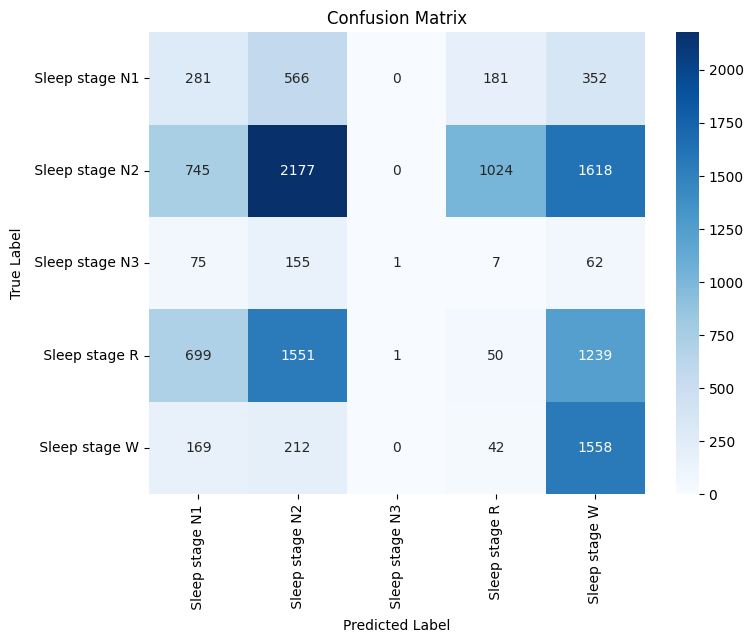

                 precision    recall  f1-score   support

 Sleep stage N1       0.14      0.20      0.17      1380
 Sleep stage N2       0.47      0.39      0.43      5564
 Sleep stage N3       0.50      0.00      0.01       300
  Sleep stage R       0.04      0.01      0.02      3540
  Sleep stage W       0.32      0.79      0.46      1981

       accuracy                           0.32     12765
      macro avg       0.29      0.28      0.22     12765
   weighted avg       0.29      0.32      0.28     12765



In [66]:
# --------------------------
# 1. Predict labels
# --------------------------
y_pred_probs = model1.predict(X_test)   # ได้เป็น probability (softmax)
y_pred = np.argmax(y_pred_probs, axis=1)  # แปลงเป็น class index
y_true = np.argmax(y_test_cat, axis=1)    # แปลง one-hot y_test กลับเป็น index

# --------------------------
# 2. Confusion matrix
# --------------------------
cm = confusion_matrix(y_true, y_pred)

# --------------------------
# 3. Plot confusion matrix
# --------------------------
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# --------------------------
# 4. (optional) Classification report
# --------------------------
print(classification_report(y_true, y_pred, target_names=encoder.classes_))